## Brain tumor predictions

Dataset downloaded from https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf

In [2]:
tf.__version__

'2.10.1'

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Data preparation

Only RGB and not TIFF photos

In [4]:
metadata = pd.read_csv('metadata_rgb_only.csv')

In [5]:
metadata.head()

,Unnamed: 0,image,class,format,mode,shape
0,0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
2,3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
3,4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"
4,5,Cancer (100).jpg,tumor,JPEG,RGB,"(512, 512, 3)"


In [6]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4461 entries, 0 to 4460
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4461 non-null   int64 
 1   image       4461 non-null   object
 2   class       4461 non-null   object
 3   format      4461 non-null   object
 4   mode        4461 non-null   object
 5   shape       4461 non-null   object
dtypes: int64(1), object(5)
memory usage: 209.2+ KB


In [7]:
metadata.describe(include=object)

,image,class,format,mode,shape
count,4461,4461,4461,4461,4461
unique,4461,2,3,1,452
top,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
freq,1,2421,4373,4461,884


In [8]:
metadata['format'].unique()

array(['JPEG', 'TIFF', 'PNG'], dtype=object)

In [9]:
metadata[metadata['format'] == 'TIFF']

,Unnamed: 0,image,class,format,mode,shape
1,2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"
114,116,Cancer (11).tif,tumor,TIFF,RGB,"(256, 256, 3)"
226,228,Cancer (12).tif,tumor,TIFF,RGB,"(256, 256, 3)"
331,340,Cancer (13).tif,tumor,TIFF,RGB,"(256, 256, 3)"
...,...,...,...,...,...,...
2244,2321,Cancer (83).tif,tumor,TIFF,RGB,"(256, 256, 3)"
2256,2333,Cancer (84).tif,tumor,TIFF,RGB,"(256, 256, 3)"
2268,2345,Cancer (85).tif,tumor,TIFF,RGB,"(256, 256, 3)"
2280,2357,Cancer (86).tif,tumor,TIFF,RGB,"(256, 256, 3)"


In [10]:
metadata[metadata['format'] == 'TIFF'].shape

(86, 6)

In [11]:
metadata_ext = pd.read_csv('metadata.csv')

In [12]:
metadata_ext.shape

(4600, 6)

In [13]:
metadata.shape

(4461, 6)

In [14]:
imgs = metadata[metadata['format'] != 'TIFF']
imgs.shape

(4375, 6)

In [15]:
imgs['class'].unique()

array(['tumor', 'normal'], dtype=object)

In [16]:
tumor_imgs = imgs[imgs['class'] == 'tumor']
tumor_imgs.shape

(2335, 6)

In [17]:
normal_imgs = imgs[imgs['class'] == 'normal']
normal_imgs.shape

(2040, 6)

In [18]:
normal_imgs_names = normal_imgs['image'].values.tolist()
normal_imgs_names[:10]

['Not Cancer  (1).jpg',
 'Not Cancer  (1).png',
 'Not Cancer  (10).jpg',
 'Not Cancer  (100).jpg',
 'Not Cancer  (1000).jpg',
 'Not Cancer  (1001).jpg',
 'Not Cancer  (1002).jpg',
 'Not Cancer  (1003).jpg',
 'Not Cancer  (1004).jpg',
 'Not Cancer  (1005).jpg']

In [19]:
tumor_imgs_names = tumor_imgs['image'].values.tolist()
tumor_imgs_names[:10]

['Cancer (1).jpg',
 'Cancer (10).jpg',
 'Cancer (100).jpg',
 'Cancer (1000).jpg',
 'Cancer (1001).jpg',
 'Cancer (1002).JPG',
 'Cancer (1003).jpg',
 'Cancer (1004).jpg',
 'Cancer (1005).jpg',
 'Cancer (1006).jpg']

In [20]:
import random

random.shuffle(tumor_imgs_names)
random.shuffle(normal_imgs_names)

In [21]:
tumor_imgs_names[:10]

['Cancer (1247).jpg',
 'Cancer (662).jpg',
 'Cancer (1676).jpg',
 'Cancer (118).jpg',
 'Cancer (32).jpg',
 'Cancer (2251).jpg',
 'Cancer (1176).JPG',
 'Cancer (2180).jpg',
 'Cancer (535).jpg',
 'Cancer (697).jpg']

In [22]:
normal_imgs_names[:10]

['Not Cancer  (1841).jpg',
 'Not Cancer  (1815).jpg',
 'Not Cancer  (422).jpg',
 'Not Cancer  (838).jpg',
 'Not Cancer  (1155).jpg',
 'Not Cancer  (750).jpg',
 'Not Cancer  (1137).jpg',
 'Not Cancer  (1542).jpg',
 'Not Cancer  (2037).jpg',
 'Not Cancer  (1735).jpg']

In [4]:
base_dir = '.\\brain_tumor_data_set'
tumor_dir = os.path.join(base_dir, 'tumor')
normal_dir = os.path.join(base_dir, 'normal')

In [5]:
new_base_dir = '.\\brain_tumor_divided'

new_train_dir = os.path.join(new_base_dir, 'train')
new_valid_dir = os.path.join(new_base_dir, 'valid')
new_test_dir = os.path.join(new_base_dir, 'test')

train_tumor = os.path.join(new_train_dir, 'tumor')
train_normal = os.path.join(new_train_dir, 'normal')

valid_tumor = os.path.join(new_valid_dir, 'tumor')
valid_normal = os.path.join(new_valid_dir, 'normal')

test_tumor = os.path.join(new_test_dir, 'tumor')
test_normal = os.path.join(new_test_dir, 'normal')


directories = [new_base_dir, new_train_dir, new_valid_dir, new_test_dir, 
               train_tumor, train_normal, valid_tumor, valid_normal, test_tumor, test_normal]

directories

['.\\brain_tumor_divided',
 '.\\brain_tumor_divided\\train',
 '.\\brain_tumor_divided\\valid',
 '.\\brain_tumor_divided\\test',
 '.\\brain_tumor_divided\\train\\tumor',
 '.\\brain_tumor_divided\\train\\normal',
 '.\\brain_tumor_divided\\valid\\tumor',
 '.\\brain_tumor_divided\\valid\\normal',
 '.\\brain_tumor_divided\\test\\tumor',
 '.\\brain_tumor_divided\\test\\normal']

In [62]:
for dir in directories:
    if not os.path.exists(dir):
        os.mkdir(dir)

In [57]:
size = min(len(tumor_imgs_names), len(normal_imgs_names))
size

2040

In [58]:
train_size = int(np.floor(0.7 * size))
valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size

print("Train size: ", train_size)
print("Valid size: ", valid_size)
print("Test size: ", test_size)

Train size:  1428
Valid size:  408
Test size:  204


In [60]:
train_idx = train_size
valid_idx = train_size + valid_size
test_idx = train_size + valid_size + test_size

In [61]:
train_normal_names = normal_imgs_names[:train_idx]
train_tumor_names = tumor_imgs_names[:train_idx]

valid_normal_names = normal_imgs_names[train_idx:valid_idx]
valid_tumor_names = tumor_imgs_names[train_idx:valid_idx]

test_normal_names = normal_imgs_names[valid_idx:test_idx]
test_tumor_names = tumor_imgs_names[valid_idx:test_idx]

In [63]:
def copy_files(names, source_dir, dest_dir):
    for name in names:
        source_location = os.path.join(source_dir, name)
        dest_location = os.path.join(dest_dir, name)
        shutil.copyfile(source_location, dest_location)

In [64]:
copy_files(train_tumor_names, tumor_dir, train_tumor)
copy_files(valid_tumor_names, tumor_dir, valid_tumor)
copy_files(test_tumor_names, tumor_dir, test_tumor)

In [67]:
copy_files(train_normal_names, normal_dir, train_normal)
copy_files(valid_normal_names, normal_dir, valid_normal)
copy_files(test_normal_names, normal_dir, test_normal)

In [6]:
print("Tumor - train size: ", len(os.listdir(train_tumor)))
print("Tumor - valid size: ", len(os.listdir(valid_tumor)))
print("Tumor - test size: ", len(os.listdir(test_tumor)))
print(" ")

print("Normal - train size: ", len(os.listdir(train_normal)))
print("Normal - valid size: ", len(os.listdir(valid_normal)))
print("Normal - test size: ", len(os.listdir(test_normal)))

Tumor - train size:  1428
Tumor - valid size:  408
Tumor - test size:  204
 
Normal - train size:  1428
Normal - valid size:  408
Normal - test size:  204


### Closer look at given data

In [7]:
from tensorflow.keras.utils import image_dataset_from_directory

def read_imgs(source_dir):
    return image_dataset_from_directory(
        directory=source_dir,
        batch_size=32,
        image_size=(256, 256),
        label_mode='binary',
        labels='inferred')

In [8]:
train = read_imgs(new_train_dir)
valid = read_imgs(new_valid_dir)
test = read_imgs(new_test_dir)

Found 2856 files belonging to 2 classes.
Found 816 files belonging to 2 classes.
Found 408 files belonging to 2 classes.


In [9]:
def plot_images(iterator):
    plt.figure(figsize=(16, 16))
    batch = iterator.as_numpy_iterator().next()
    for i in range(12):
        plt.subplot(4,3,i+1)
        image = batch[0][i].astype('uint8')
        title = "Class :" + str(int(batch[1][i][0]))
        plt.imshow(image)
        plt.title(title)

    plt.show()

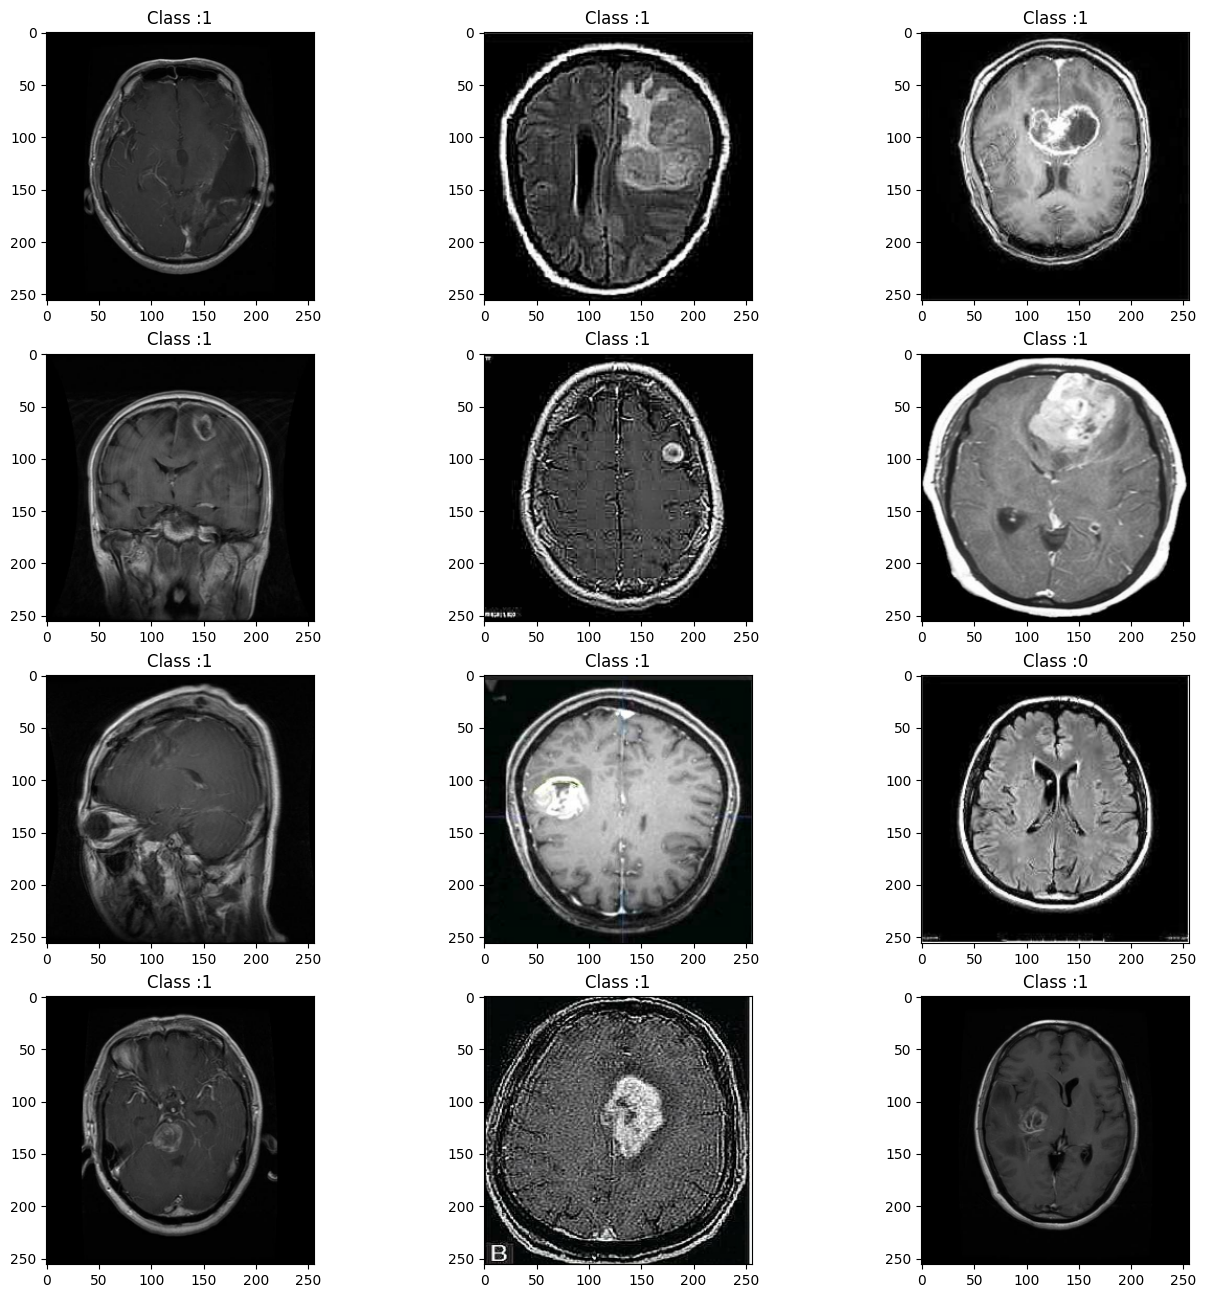

In [10]:
plot_images(valid)

### Neural network model building and training

In [11]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

model = Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical', input_shape=(256, 256, 3)),
    layers.RandomContrast(factor=0.2),
    layers.RandomBrightness(factor=0.2),
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_contrast (RandomCont  (None, 256, 256, 3)      0         
 rast)                                                           
                                                                 
 random_brightness (RandomBr  (None, 256, 256, 3)      0         
 ightness)                                                       
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0

In [13]:
model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [14]:
EPOCHS = 20

history = model.fit(train,
                    epochs=EPOCHS, 
                    validation_data=valid)

Epoch 1/20
90/90 [==============================] - 39s 375ms/step - loss: 0.7914 - accuracy: 0.6453 - val_loss: 0.5394 - val_accuracy: 0.7537
Epoch 2/20
90/90 [==============================] - 33s 369ms/step - loss: 0.4149 - accuracy: 0.8200 - val_loss: 0.4412 - val_accuracy: 0.8223
Epoch 3/20
90/90 [==============================] - 33s 368ms/step - loss: 0.2614 - accuracy: 0.8890 - val_loss: 0.2884 - val_accuracy: 0.8897
Epoch 4/20
90/90 [==============================] - 33s 368ms/step - loss: 0.1600 - accuracy: 0.9363 - val_loss: 0.3594 - val_accuracy: 0.8873
Epoch 5/20
90/90 [==============================] - 33s 368ms/step - loss: 0.0893 - accuracy: 0.9681 - val_loss: 0.3192 - val_accuracy: 0.9093
Epoch 6/20
90/90 [==============================] - 33s 367ms/step - loss: 0.0686 - accuracy: 0.9800 - val_loss: 0.3639 - val_accuracy: 0.9081
Epoch 7/20
90/90 [==============================] - 33s 368ms/step - loss: 0.0384 - accuracy: 0.9874 - val_loss: 0.3616 - val_accuracy: 0.9044

In [15]:
def validation_and_accuracy_graphs(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

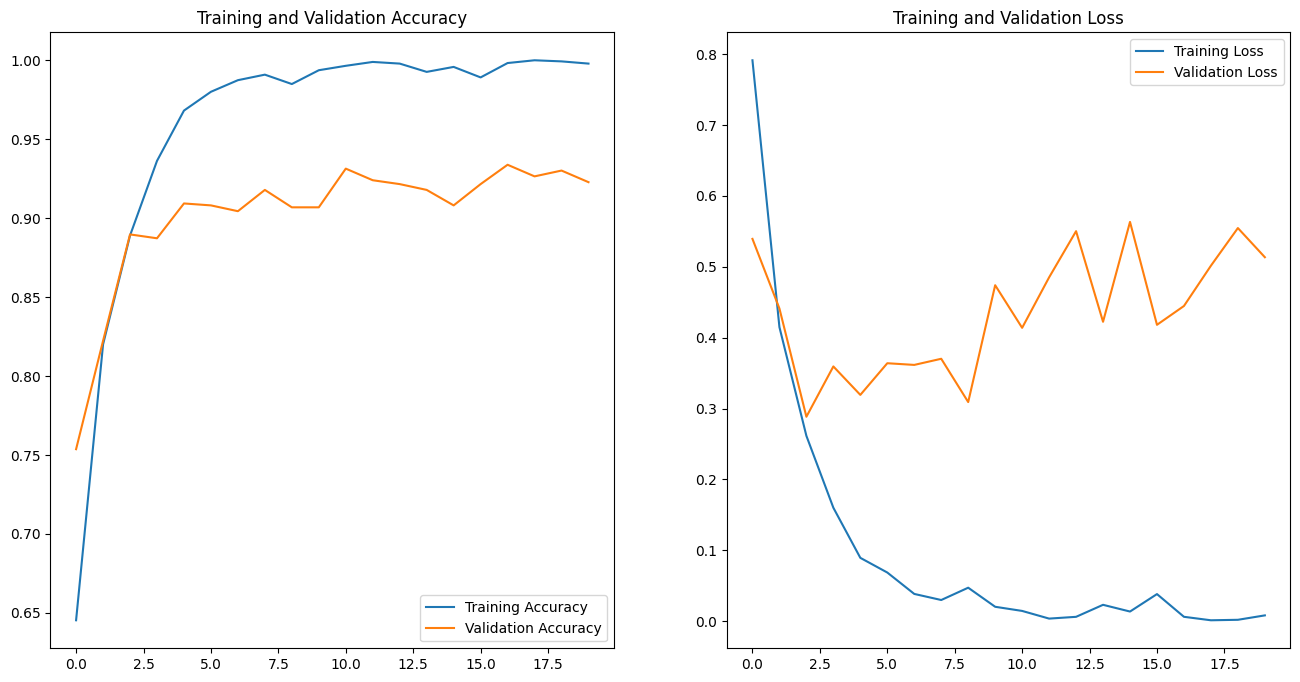

In [16]:
validation_and_accuracy_graphs(history, EPOCHS)

### Evaluation and testing

In [17]:
loss, accuracy = model.evaluate(test)

13/13 [==============================] - 1s 56ms/step - loss: 0.4987 - accuracy: 0.9240


In [18]:
print("Brain tumor recognition accuracy : ", accuracy)

Brain tumor recognition accuracy :  0.9240196347236633


In [19]:
model.save("brain_tumor_model")

INFO:tensorflow:Assets written to: brain_tumor_model\assets


INFO:tensorflow:Assets written to: brain_tumor_model\assets


In [93]:
test = image_dataset_from_directory(
        directory=new_test_dir,
        batch_size=2*len(os.listdir(test_normal)),
        image_size=(256, 256),
        label_mode='binary',
        labels='inferred')

Found 408 files belonging to 2 classes.


In [94]:
test_batch = test.as_numpy_iterator().next()

In [95]:
imgs = test_batch[0]
classes = test_batch[1]

In [96]:
predicted_fractions = model.predict(imgs)

13/13 [==============================] - 0s 24ms/step


In [97]:
predicted_fractions[:10]

array([[2.8514847e-12],
       [3.2867621e-23],
       [9.9999928e-01],
       [9.9868339e-01],
       [9.9704081e-01],
       [9.9410433e-01],
       [7.6762925e-09],
       [9.9998271e-01],
       [8.0358857e-01],
       [9.9985111e-01]], dtype=float32)

In [98]:
predicted_classes = []
for frc in predicted_fractions:
    if frc[0] > 0.5:
        predicted_classes.append(1)
    else:
        predicted_classes.append(0)

predicted_classes[:10]   

[0, 0, 1, 1, 1, 1, 0, 1, 1, 1]

In [99]:
processed_classes= []
for cls in classes:
    processed_classes.append(int(cls[0]))

processed_classes[:10]

[0, 0, 1, 1, 1, 1, 0, 1, 1, 1]

In [100]:
comparison = pd.DataFrame({
    'true_classes': processed_classes,
    'predicted_classes': predicted_classes,
})

comparison

,true_classes,predicted_classes
0,0,0
1,0,0
2,1,1
3,1,1
4,1,1
...,...,...
403,1,1
404,0,0
405,0,0
406,0,1


In [101]:
comparison['error'] = comparison['true_classes'] !=  comparison['predicted_classes']
comparison

,true_classes,predicted_classes,error
0,0,0,False
1,0,0,False
2,1,1,False
3,1,1,False
4,1,1,False
...,...,...,...
403,1,1,False
404,0,0,False
405,0,0,False
406,0,1,True


In [102]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(comparison['true_classes'], comparison['predicted_classes'])
cm

array([[184,  20],
       [ 11, 193]], dtype=int64)

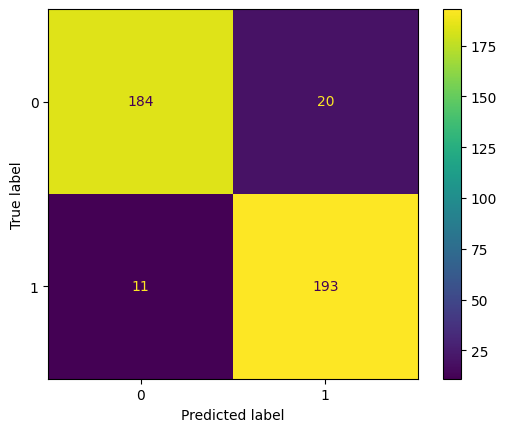

In [103]:
ConfusionMatrixDisplay(cm).plot()

In [107]:
error_indexes = comparison[comparison['error'] == True].index
error_indexes

Int64Index([ 10,  17,  19,  32,  45,  58,  59,  64,  93,  97,  99, 129, 160,
            164, 191, 201, 211, 221, 226, 239, 272, 280, 288, 292, 298, 299,
            317, 345, 371, 393, 406],
           dtype='int64')

In [108]:
len(error_indexes)

31

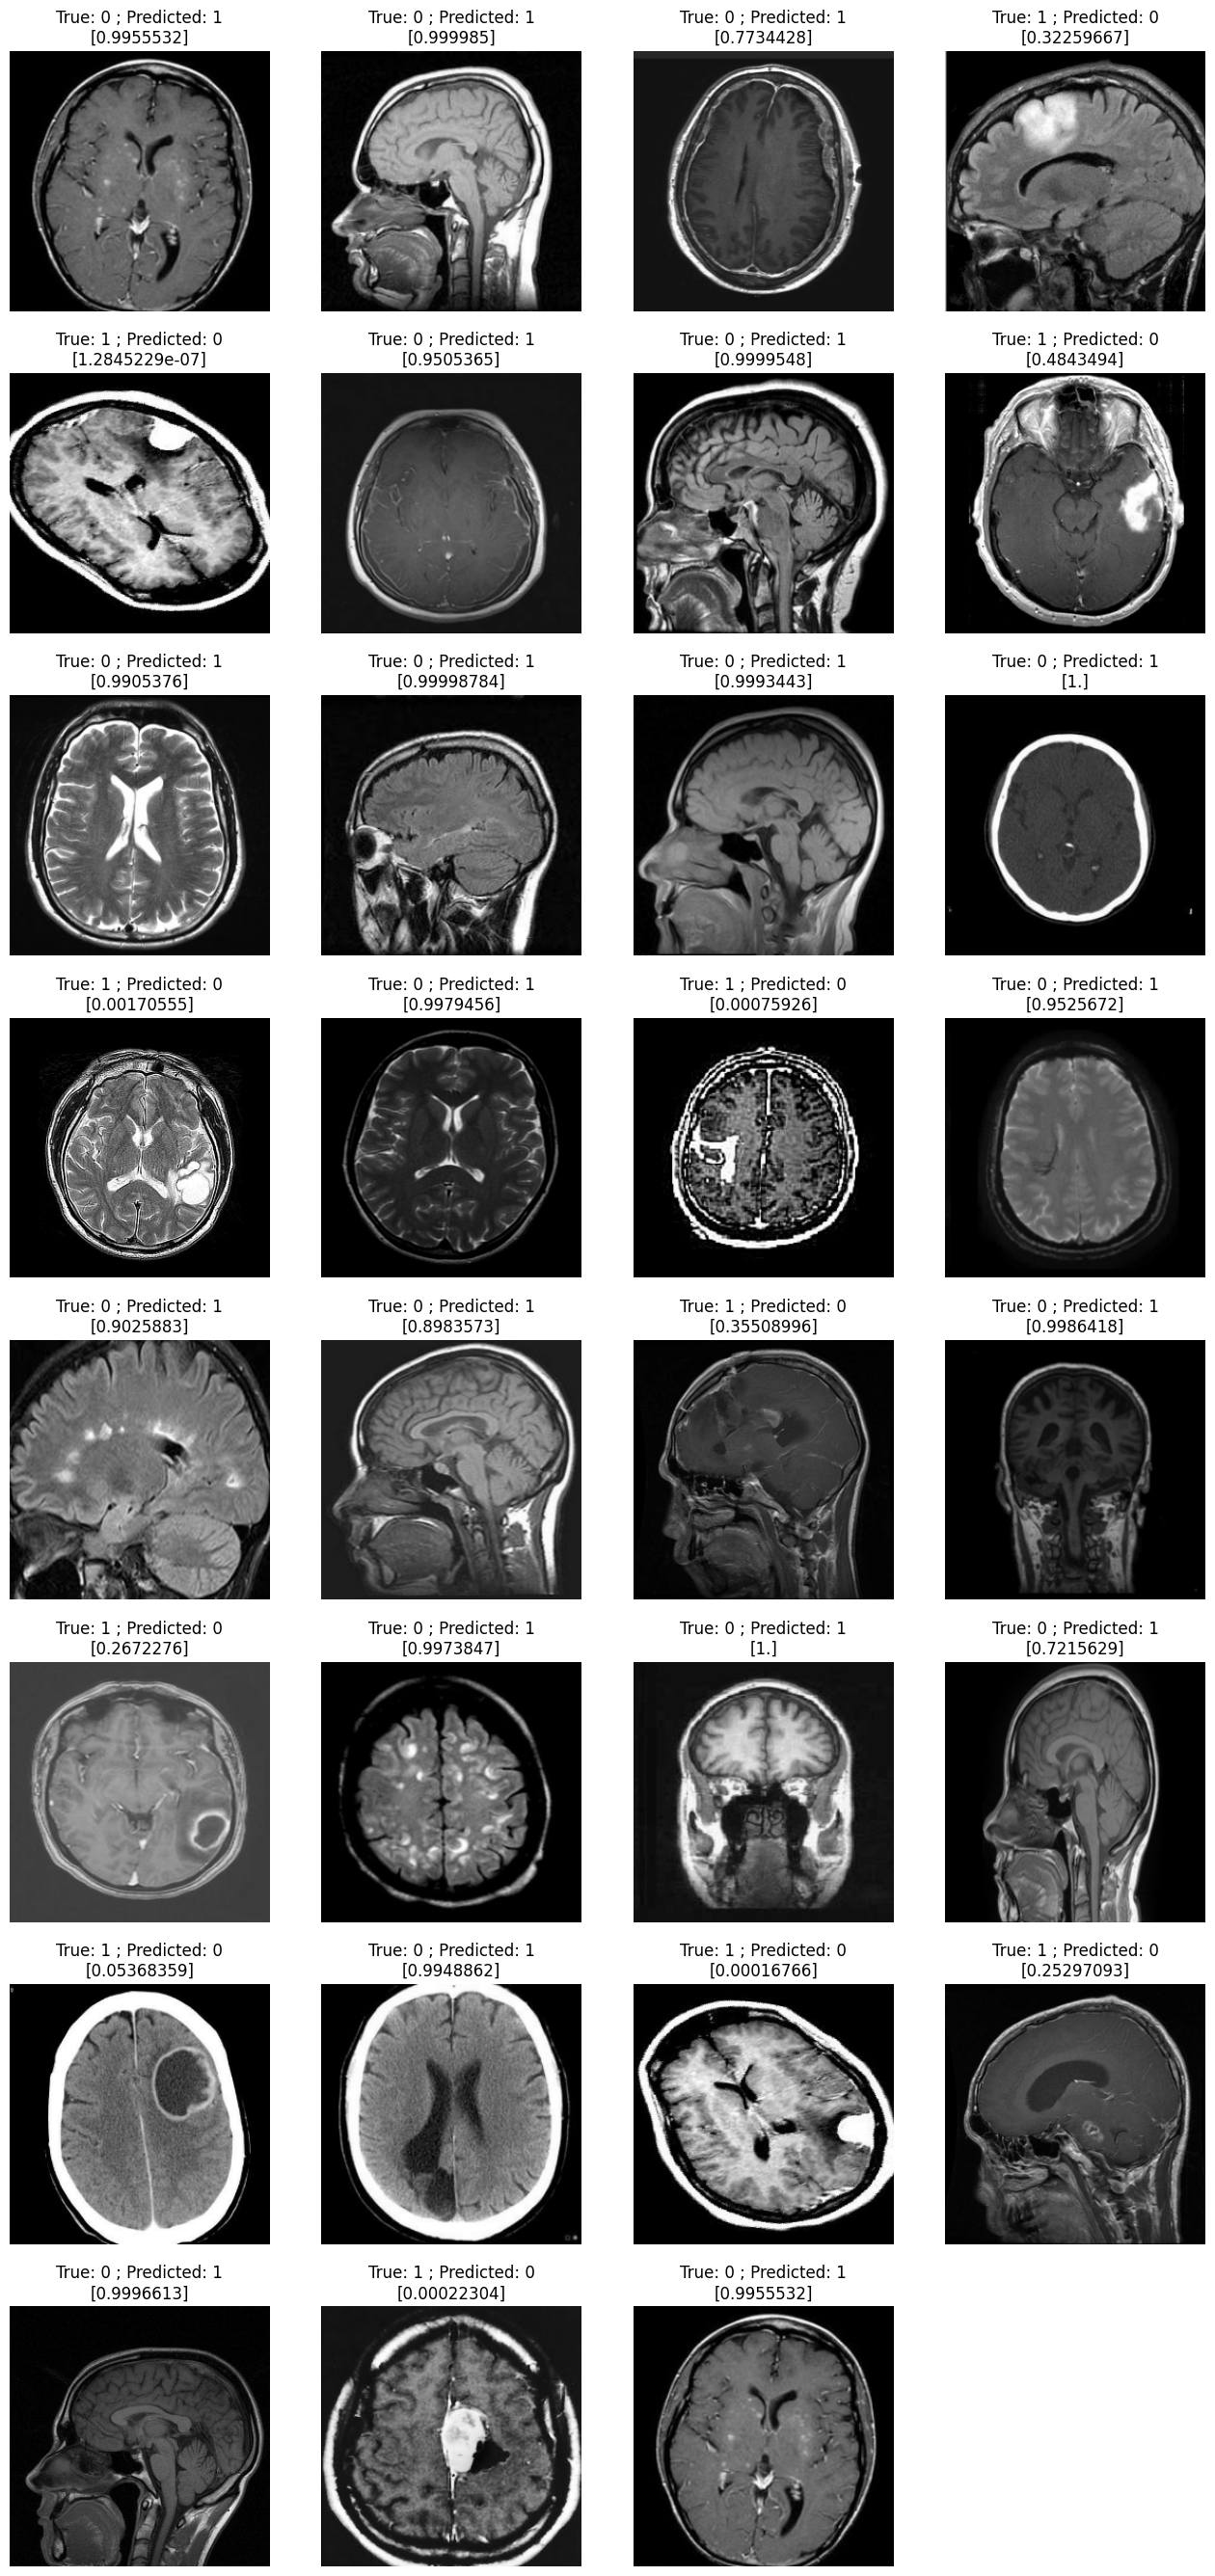

In [115]:
plt.figure(figsize=(16, 34))
i = 1

for idx in error_indexes:
    info = comparison.loc[idx]
    true = info['true_classes']
    predicted = info['predicted_classes']
    title = "True: " + str(true) + " ; Predicted: " + str(predicted) + "\n" + str(predicted_fractions[idx])
    plt.subplot(8, 4, i)
    plt.imshow(imgs[idx].astype('uint8'))
    plt.axis('off')
    plt.title(title)
    i+=1
    
plt.show()

In [118]:
print(classification_report(comparison['true_classes'], comparison['predicted_classes']))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       204
           1       0.91      0.95      0.93       204

    accuracy                           0.92       408
   macro avg       0.92      0.92      0.92       408
weighted avg       0.92      0.92      0.92       408



In this situation it can be useful to classify images as class 1 if predicted fraction is lower than 0.5 (for example 0.2).
Thanks to this, we can avoid some "False Negatives" (patients with tumor but classified as healthy).

##### All in all, 92% accuracy in such simple neural network is really good result.